# Exploración de  regresión logística 

## Imports y carga de datasets

In [1]:
 %load_ext autoreload
%autoreload 2

In [2]:
from pipeline import eval_pipeline, HierarchicalImputer, CoordinateTransformer, WindDirectionTransformer, DropColumnsTransformer, RainTodayTransformer, ExpandDateTransformer, sample, report_results, ShapeDebugger, BinningTransformer, LabelBinarizerPipelineFriendly, DistanceFromCenterTransformer
from persistence import load_or_fit
# For data manipulation
import pandas as pd
import numpy as np
import pandas as pd
# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib

In [3]:
rains = pd.read_csv('../data/weatherAUS.csv')
rains = rains.dropna(subset=['RainTomorrow'])
# Convierto la variable 'Date' a formato tipo "datetime" de Pandas

rains_x = rains.drop(columns=['RainTomorrow'])  # Drop the target column from features
rains_y = np.where(rains['RainTomorrow'] == "Yes", 1, 0)                 # Target variable

# Split the dataset
rnd_seed = 42   # For reproducibility         
ftest = 0.20    # Fracción de datos para "train"

X_train, X_test, y_train, y_test = train_test_split(rains_x, rains_y,
                                                    test_size=ftest,
                                                    stratify=rains_y,
                                                    random_state=rnd_seed)

print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (113754, 22)
Valores de y_train: 113754
Dimension de X_test: (28439, 22)
Valores de y_test: 28439


In [4]:
coordinates = pd.read_csv("../data/worldcities.csv")
coordinates["Location"] = coordinates["city"]
coordinates.drop(columns=["city"], inplace = True)
coordinates = coordinates[coordinates["country"] == "Australia"]

city_coords = {
    'Albury': (-36.0785, 146.9136),
    'BadgerysCreek': (-33.8813, 150.7282),
    'Cobar': (-31.8667, 145.7667),
    'CoffsHarbour': (-30.3026, 153.1137),
    'Moree': (-29.4706, 149.8392),
    'Newcastle': (-32.9283, 151.7817),
    'NorahHead': (-33.2202, 151.5433),
    'NorfolkIsland': (-29.0408, 167.9541),
    'Penrith': (-33.7675, 150.6931),
    'Richmond': (-33.5982, 150.7581),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753),
    'WaggaWagga': (-35.0433, 147.3587),
    'Williamtown': (-32.7951, 151.8118),
    'Wollongong': (-34.4278, 150.8931),
    'Canberra': (-35.2809, 149.1300),
    'Tuggeranong': (-35.4167, 149.1000),
    'MountGinini': (-35.4471, 148.9685),
    'Ballarat': (-37.5622, 143.8503),
    'Bendigo': (-36.7582, 144.2814),
    'Sale': (-38.1100, 147.0737),
    'MelbourneAirport': (-37.6692, 144.8411),
    'Melbourne': (-37.8136, 144.9631),
    'Mildura': (-34.1850, 142.1625),
    'Nhil': (-35.2060, 141.6450),
    'Portland': (-38.3516, 141.5878),
    'Watsonia': (-37.7139, 145.0875),
    'Dartmoor': (-37.7251, 141.2843),
    'Brisbane': (-27.4698, 153.0251),
    'Cairns': (-16.9203, 145.7710),
    'GoldCoast': (-28.0167, 153.4000),
    'Townsville': (-19.2589, 146.8183),
    'Adelaide': (-34.9285, 138.6007),
    'MountGambier': (-37.8321, 140.7807),
    'Nuriootpa': (-34.4973, 138.9966),
    'Woomera': (-31.1395, 136.7984),
    'Albany': (-35.0285, 117.8837),
    'Witchcliffe': (-33.7015, 115.0911),
    'PearceRAAF': (-31.9131, 115.9741),
    'PerthAirport': (-31.9402, 115.9676),
    'Perth': (-31.9505, 115.8605),
    'SalmonGums': (-33.3937, 121.2060),
    'Walpole': (-34.9639, 115.8106),
    'Hobart': (-42.8821, 147.3272),
    'Launceston': (-41.4391, 147.1349),
    'AliceSprings': (-23.6980, 133.8807),
    'Darwin': (-12.4634, 130.8456),
    'Katherine': (-14.4686, 132.2678),
    'Uluru': (-25.3444, 131.0369)
}

# Estrategia de imputación: Categorical => numerical

Se transforman las direcciones cardinales en grados, ej NE -> 0.22

Se transforma la ubicacion (Location) en latitud y longitud, ej Albury => (-36.0785, 146.9136)

In [5]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])

parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)
report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Saving: num-minmax-logit-9909.pkl
Accuracy: 0.8021168486382897

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7801939106880155
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6138570829354502


Accuracy: 0.8026355117182693

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7802633072161551
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6374295746255516


Vemos como cambia la precision y el recall cambiando el valor umbral

In [10]:
probas = pd.DataFrame(gs_fitted.predict_proba(x))
report_results(y, np.where(probas[1] > 0.9, 1, 0))

Accuracy: 0.822945054945055

 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90      8824
           1       0.86      0.25      0.39      2551

    accuracy                           0.82     11375
   macro avg       0.84      0.62      0.64     11375
weighted avg       0.83      0.82      0.78     11375


 Roc auc Report:
 0.6196046481336492


In [14]:
report_results(y, np.where(probas[1] > 0.6, 1, 0))

Accuracy: 0.8246153846153846

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      8824
           1       0.60      0.65      0.62      2551

    accuracy                           0.82     11375
   macro avg       0.75      0.76      0.75     11375
weighted avg       0.83      0.82      0.83     11375


 Roc auc Report:
 0.762109249639183


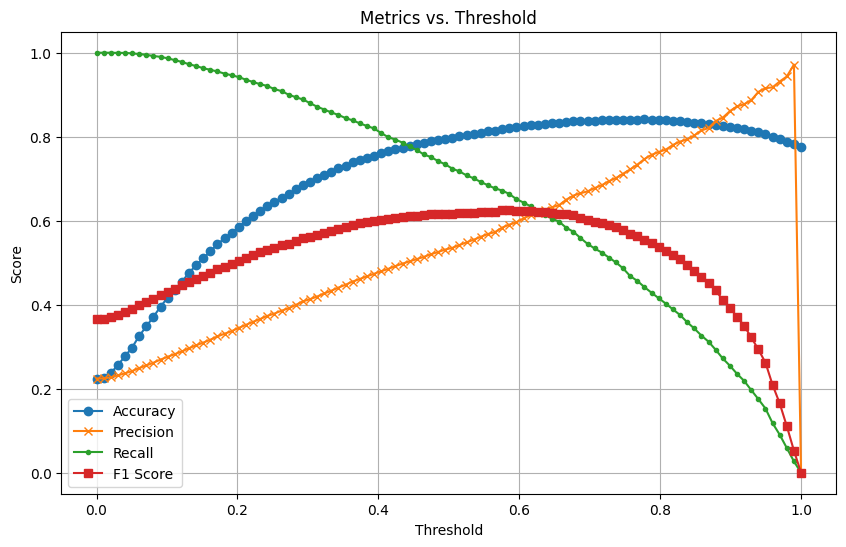

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

thresholds = np.linspace(0, 1, 100)

# Metrics storage
accuracies = []
precisions = []
recall = []
f1_scores = []
y_true = y

# Compute metrics for each threshold
for threshold in thresholds:
    y_pred = (probas[1] >= threshold).astype(int)  # Apply threshold
    accuracies.append(accuracy_score(y_true, y_pred))
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recall.append(recall_score(y_true, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, zero_division=0))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label="Accuracy", marker='o')
plt.plot(thresholds, precisions, label="Precision", marker='x')
plt.plot(thresholds, recall, label="Recall", marker='.')
plt.plot(thresholds, f1_scores, label="F1 Score", marker='s')

# Customize plot
plt.title("Metrics vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

###  Missclassifications

Se hace un pequeño análisis de las distribuciones de las observaciones mal clasificadas.

No se hace una implementación que tome ventaja de esto ya que se explorara en la sección de Boosting.

In [17]:
num_minmax_logit_preproc =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
], memory="pipeline_cache")
x_t = num_minmax_logit_preproc.fit_transform(x)

/tmp/ipykernel_55836/2399821194.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missclassified['target'] = y[y != y_pred]
/tmp/ipykernel_55836/2399821194.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=missclassified, x=c, hue='target', fill=True, common_norm=False, ax=ax)


IndexError: index 21 is out of bounds for axis 0 with size 21

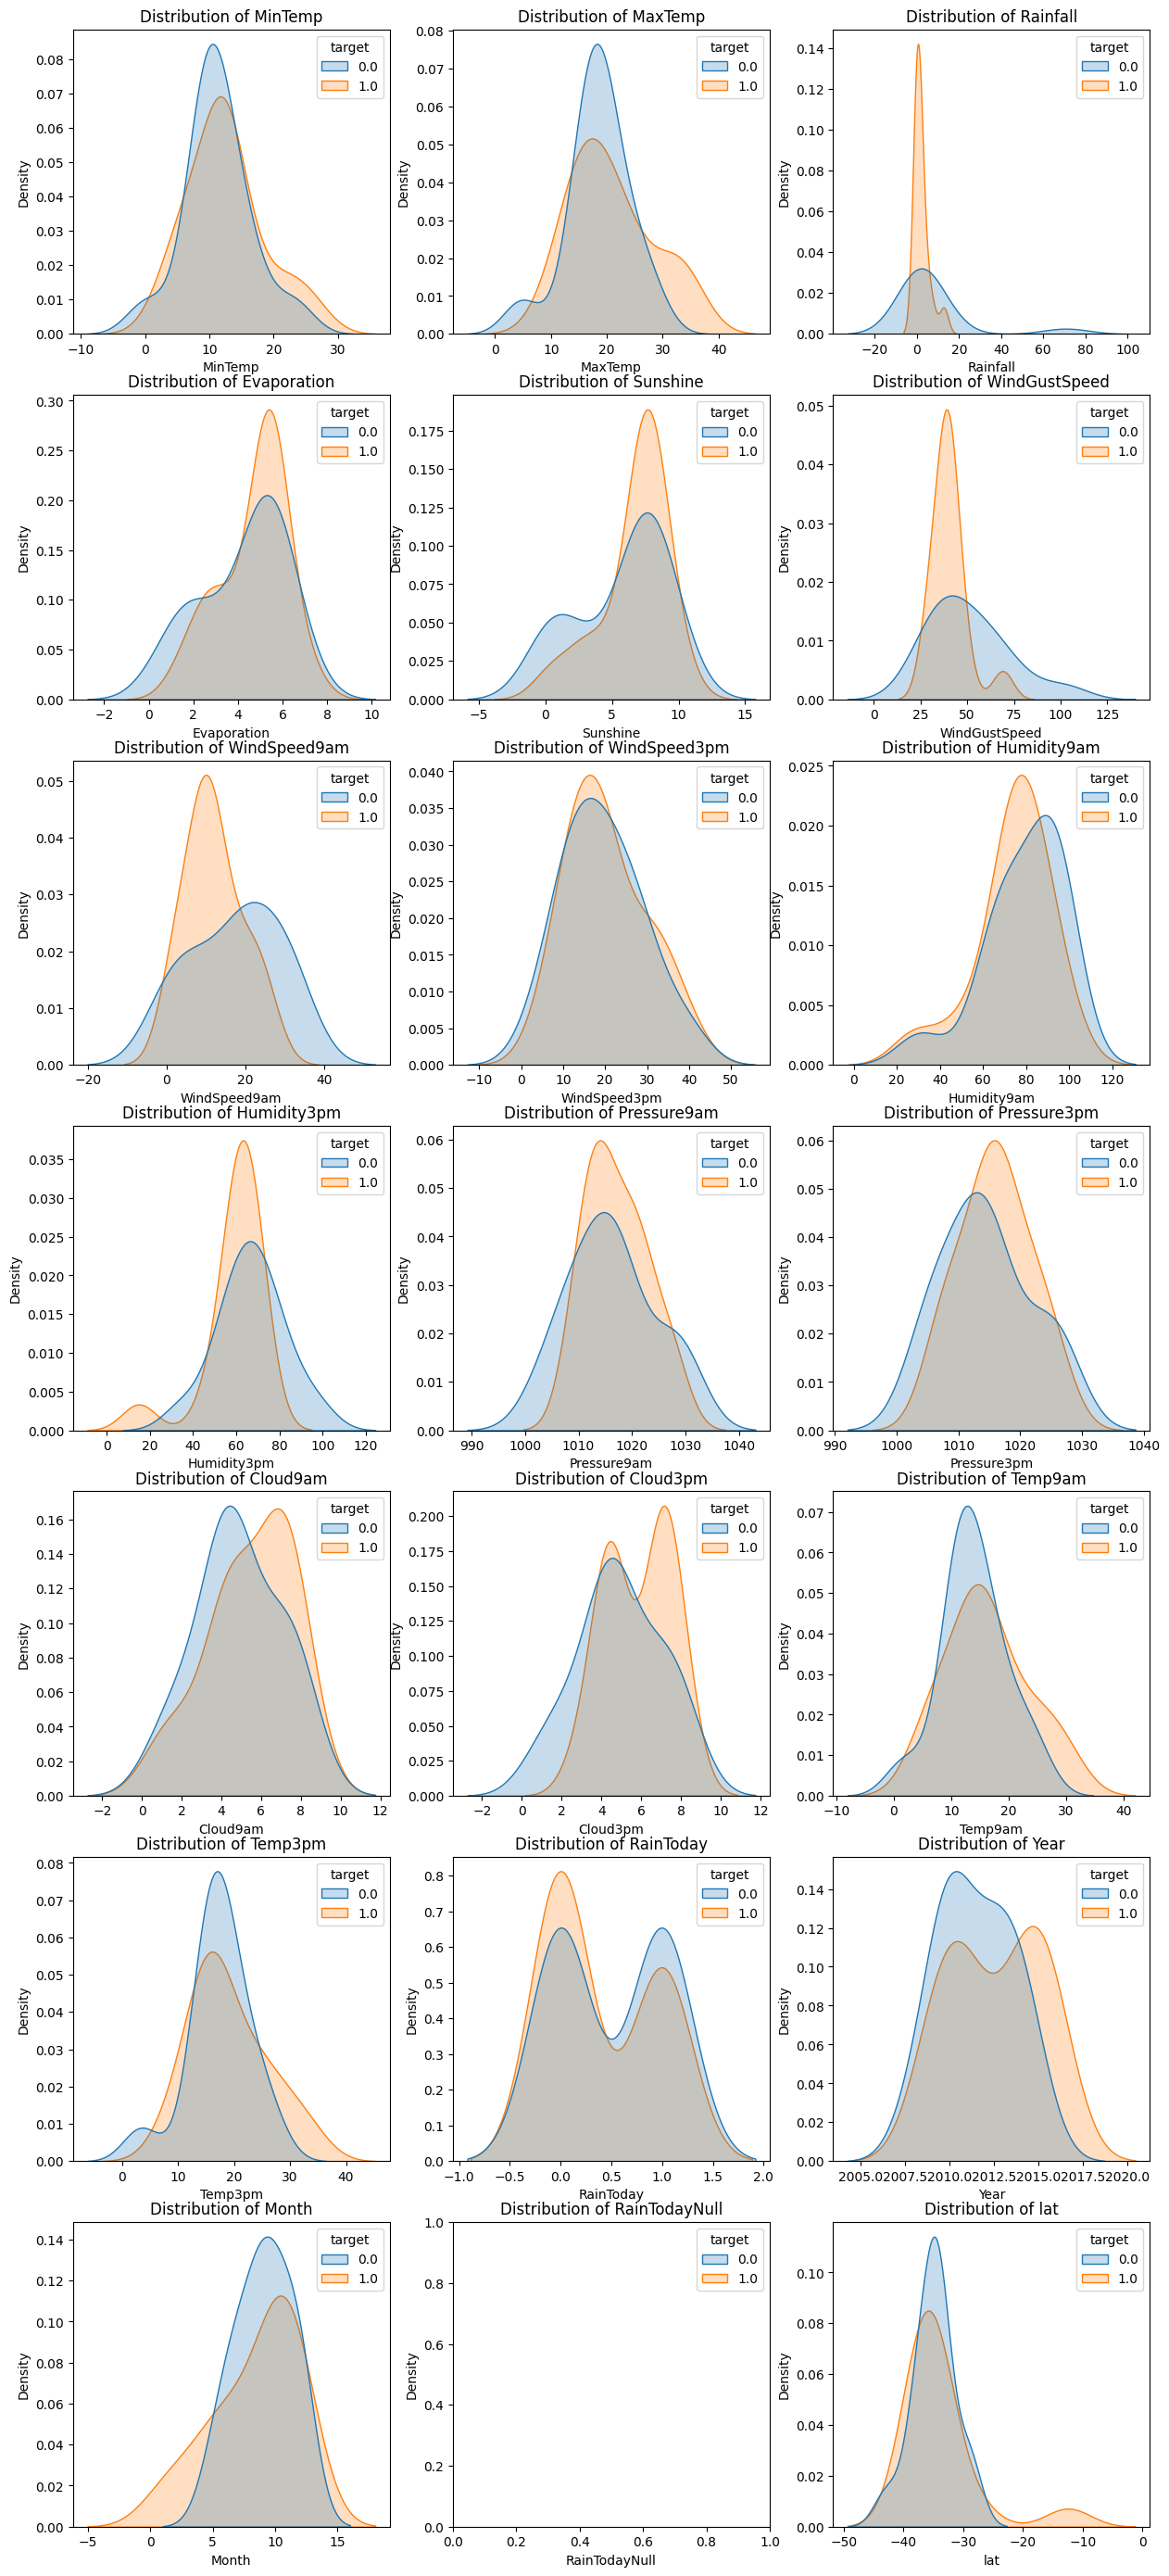

In [18]:
# missclassified = x_t[(y_pred != y).reset_index(drop=True)]
# missclassified['target'] = y[y != y_pred]
# for c in x_t.columns:
#   plt.figure(figsize=(10,10))
#   sns.displot(data=missclassified, x=c, hue='target', kind="kde")
#   plt.show()

y_pred = gs_fitted.predict(x)
# Identify misclassified samples
missclassified = x_t[(y_pred != y).reset_index(drop=True)]
missclassified['target'] = y[y != y_pred]

# Number of features
num_features = len(X_test.columns)

# Set grid size (adjust rows and columns based on the number of features)
cols = 3  # Number of plots per row
rows = num_features  // cols  # Calculate required rows

# Create grid plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot KDEs for each feature
for idx, c in enumerate(x_t.columns):
    ax = axes[idx]
    sns.kdeplot(data=missclassified, x=c, hue='target', fill=True, common_norm=False, ax=ax)
    ax.set_title(f'Distribution of {c}')
    ax.set_xlabel(c)
    ax.set_ylabel('Density')

# Hide unused subplots
for idx in range(len(X_test.columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

##  Elasticnet

Ahora exploramos si combinación entre regularización l1 y l2 nos puede mejorar el socore.

In [104]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.95],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
    'logistic_regression__C': [2.0, 5.0],
    'logistic_regression__max_iter': [1000]
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


{'logistic_regression__C': 5.0, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.95, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}


Accuracy: 0.8026267208186085

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7813728985347294


### Resultado de la regularizacion:

Como resultado podemos ver que los features mas importantes son: 
- Pressure3pm     13.663893
- Pressure9am      9.439823
- WindGustSpeed    6.620914
- Humidity3pm      5.442283
- Rainfall         4.234356
- MaxTemp          2.349363

In [ ]:
pd.DataFrame(gs_fitted.best_estimator_.named_steps['logistic_regression'].coef_, columns=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDeg', 'WindDir9amDeg', 'WindDir3pmDeg']).T.abs().sort_values(by=0, ascending=False)

,0
Pressure3pm,13.663893
Pressure9am,9.439823
WindGustSpeed,6.620914
Humidity3pm,5.442283
Rainfall,4.234356
MaxTemp,2.349363
WindSpeed3pm,1.901980
Temp3pm,1.849281
Sunshine,1.847856
RainTodayNull,1.773773


### Exploracion en detalle del hyperparametro  l1_ratio


In [20]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__class_weight,param_logistic_regression__penalty,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,2.626154,0.487477,0.567349,0.124751,"{1: 0.6, 0: 0.4}",l2,StandardScaler(),"{'logistic_regression__class_weight': {1: 0.6,...",0.617464,0.618070,0.581053,0.611691,0.635721,0.612800,0.017799,2
4,2.891026,0.519910,0.641695,0.115988,"{1: 0.75, 0: 0.25}",l2,MinMaxScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.612957,0.611018,0.597164,0.613712,0.616987,0.610368,0.006877,3
5,2.325948,0.494807,0.502463,0.126917,"{1: 0.75, 0: 0.25}",l2,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.609635,0.612177,0.601479,0.619765,0.626230,0.613857,0.008507,1


Exploramos mas el rango $0.25 <= l1 0.75$

In [85]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.25, 0.35, 0.45, 0.65, 0.75],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Saving: num-minmax-logit-elastic-8370.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.45, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': StandardScaler()}


Accuracy: 0.80264430261793

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7813424075884704


In [139]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_regression__class_weight,param_logistic_regression__l1_ratio,param_logistic_regression__penalty,param_logistic_regression__solver,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,3.859030,0.963758,0.701767,0.175408,"{1: 0.75, 0: 0.25}",0.35,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601185,0.613223,0.609650,0.006998,3
5,3.271553,0.524254,0.598792,0.159636,"{1: 0.75, 0: 0.25}",0.45,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601185,0.613223,0.609650,0.006998,3
7,3.886000,0.993439,0.688643,0.193535,"{1: 0.75, 0: 0.25}",0.65,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.616967,0.615649,0.601227,0.601695,0.613730,0.609854,0.006931,2
9,2.723910,0.231482,0.407015,0.027385,"{1: 0.75, 0: 0.25}",0.75,elasticnet,saga,StandardScaler(),{'logistic_regression__class_weight': {1: 0.75...,0.617496,0.615649,0.601227,0.601695,0.614238,0.610061,0.007099,1


Exploramos mas el rango $0.0.75 <= l1 1.0$

In [84]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory = "pipeline_cache")


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__l1_ratio': [0.75, 0.80, 0.85, 0.90, 0.95, 1.0],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
    'logistic_regression__C': [100],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Saving: num-minmax-logit-elastic-7903.pkl
{'logistic_regression__C': 100, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.75, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}


Accuracy: 0.8026970480158939

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7814600454207973


In [ ]:
results = pd.DataFrame(gs_fitted.cv_results_)
results[results["rank_test_score"] <= 3]

Vemos que 

## Binning

In [144]:

num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("binning", ColumnTransformer(transformers=[
        ("bin_with_slope", BinningTransformer(), ["Rainfall", "Evaporation"])
    ], remainder='passthrough')),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)

report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Saving: num-minmax-logit-2947.pkl


Accuracy: 0.8025476027216626

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.54      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7801648291421255
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6221716654419613


## Polynomial expansion

Pressure3pm     13.663893
Pressure9am      9.439823
WindGustSpeed    6.620914
Humidity3pm      5.442283
Rainfall         4.234356
MaxTemp          2.349363


In [161]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("column_transformer", ColumnTransformer(transformers=[
        ("poly_exp", PolynomialFeatures(degree=3), ["Pressure3pm", "Pressure9am", "WindGustSpeed", "Humidity3pm", "Rainfall", "MaxTemp"])
    ], remainder='passthrough')),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory="pipeline_cache")


parameters = {
    'scaler': [StandardScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__C': [5.0],
    'logistic_regression__max_iter': [1000]
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)

report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Saving: num-minmax-logit-1887.pkl


Accuracy: 0.8076023700265486

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87     88252
           1       0.55      0.74      0.63     25502

    accuracy                           0.81    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.81      0.82    113754


 Roc auc Report:
 0.7817914824465155
{'logistic_regression__C': 5.0, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6106417537780231


## Nonlinear transform

In [180]:
num_minmax_logit =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("column_transformer", ColumnTransformer(transformers=[
        ("log", FunctionTransformer(np.log1p), ["Rainfall", "Evaporation"]),
        ("sin_degree", FunctionTransformer(np.sin), ["WindGustDirDeg", "WindDir9amDeg", "WindDir3pmDeg"]),
        ("cos_degree", FunctionTransformer(np.cos), ["WindGustDirDeg", "WindDir9amDeg", "WindDir3pmDeg"])
    ], remainder='passthrough')),
    ("scaler", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())
], memory="pipeline_cache")


parameters = {
    'scaler': [MinMaxScaler()],
    'logistic_regression__class_weight':[{1: 0.75, 0: 0.25}],
    'logistic_regression__C': [5.0, 100],
    'logistic_regression__max_iter': [1000],
    'logistic_regression__l1_ratio': [0.75, 0.80, 0.85, 0.90, 0.95, 1.0],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)

report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Saving: num-minmax-logit-9472.pkl


Accuracy: 0.7983279708845403

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86     88252
           1       0.54      0.75      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.74    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7811675139769595
{'logistic_regression__C': 100, 'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__l1_ratio': 0.8, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}
0.6177136788293962


In [181]:
pd.DataFrame(gs_fitted.best_estimator_.named_steps['logistic_regression'].coef_, columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDegSin', 'WindDir9amDegSin', 'WindDir3pmDegSin',
       'WindGustDirDegSin', 'WindDir9amDegSin', 'WindDir3pmDegSin']).T.abs().sort_values(by=0, ascending=False)

,0
Year,13.709753
RainToday,9.339283
Temp3pm,5.271173
Pressure3pm,5.073461
Pressure9am,1.722060
lat,1.555150
WindGustDirDegSin,1.465224
MinTemp,1.243830
RainTodayNull,1.236172
Humidity3pm,1.147467


# One hot encoding categorical features


In [73]:
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

numerical_transformer = Pipeline(steps=[
    ("minmax", MinMaxScaler())
])


transform_columns = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, ["Location","WindGustDir", "WindDir9am", "WindDir3pm"]),
        ("num", numerical_transformer, ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'Year', 'Month'])
    ]
)


ohe_pipeline = Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("drop_date", DropColumnsTransformer(columns=["Date"])),
    ("preproc", transform_columns),
    ("logistic_regression", LogisticRegression()),
], memory="pipeline_cache")


In [ ]:

parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__C': [1, 50, 100]
}
clf = GridSearchCV(ohe_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="ohe-logit", force=True)

print(gs_fitted.best_params_)
print(gs_fitted.best_score_)
print(gs_fitted.scorer_)


In [69]:
report_results(y_train, gs_fitted.predict(X_train))

Accuracy: 0.8062485714788051

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.55      0.75      0.63     25502

    accuracy                           0.81    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.84      0.81      0.82    113754


 Roc auc Report:
 0.7845296252278586


## OHE con newton-cholesky

In [146]:
parameters = {
    'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2'],
    'logistic_regression__solver': ['newton-cholesky']
}
clf = GridSearchCV(ohe_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.3)
gs_fitted = load_or_fit(clf, x, y, name="ohe-logit-nc")

print(gs_fitted.best_params_)
print(gs_fitted.best_score_)
print(gs_fitted.scorer_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Saving: ohe-logit-nc-5197.pkl
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'newton-cholesky'}
0.6286214215567321
make_scorer(f1_score, response_method='predict', average=binary)


In [147]:
report_results(y_train, gs_fitted.predict(X_train))

Accuracy: 0.803417901788069

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87     88252
           1       0.55      0.74      0.63     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.75    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7819664462614495


# Exploration

In [83]:
num_minmax_p =  Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
 ])

x, y = sample(X_train, y_train)

x_t = num_minmax_p.fit_transform(x)

In [ ]:
x_t.head()

In [63]:
x_t.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'RainTodayNull',
       'lat', 'lng', 'WindGustDirDeg', 'WindDir9amDeg', 'WindDir3pmDeg'],
      dtype='object')

In [ ]:
y_t = y.reset_index(drop=True)
x_t['target'] = y
for c in x_t.columns:
  plt.figure(figsize=(10,10))
  sns.displot(data=x_t, x=c, hue='target', kind="kde")
  plt.show()

In [ ]:
y_t = y.reset_index(drop=True)
x_t['target'] = y
plt.figure(figsize=(10,10))
sns.scatterplot(data=x_t, x=np.log(x_t['Rainfall'] + 1), y='target', hue='target')
plt.show()
sns.scatterplot(data=x_t, x=x_t['Rainfall'], y='target', hue='target')
plt.show()
plt.hist(x=np.log(x_t['Rainfall'] + 1), bins=10)


In [109]:
x_t['Rainfall'].describe()

count    11375.000000
mean         2.393218
std          9.078005
min          0.000000
25%          0.000000
50%          0.000000
75%          0.800000
max        240.000000
Name: Rainfall, dtype: float64

In [12]:

distance_from_center_pipeline = Pipeline(steps = [
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("distance_from_center", DistanceFromCenterTransformer()),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("minmax", MinMaxScaler()),
    ("logistic_regression", LogisticRegression())

])

parameters = {
        'logistic_regression__class_weight':['balanced', {1: 0.60, 0: 0.40}, {1: 0.75, 0: 0.25}, {1: 0.85, 0: 0.15}, {1: 0.95, 0: 0.05}, None],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(distance_from_center_pipeline, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.5)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)
report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/home/leocenturion/.cache/pypoetry/virtualenvs/rain-in-australia-weQ6lB7a-py3.11/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Saving: num-minmax-logit-3428.pkl


Accuracy: 0.7992246426499288

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.86     88252
           1       0.54      0.74      0.62     25502

    accuracy                           0.80    113754
   macro avg       0.73      0.78      0.74    113754
weighted avg       0.83      0.80      0.81    113754


 Roc auc Report:
 0.7791245508185038
{'logistic_regression__class_weight': {1: 0.75, 0: 0.25}, 'logistic_regression__penalty': 'l2'}
0.6305192558043862


# Resampling

In [20]:
import imblearn as imb

num_minmax_logit =  imb.pipeline.Pipeline(steps = [
  ("date_expander", ExpandDateTransformer()),
  ("imputer", HierarchicalImputer()),
  ("rain_today", RainTodayTransformer()),
  ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
  ("wind_direction", WindDirectionTransformer()),
  ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
  ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
  ("scaler", MinMaxScaler()),
  ("resample", SMOTE(random_state=42)),
  ("logistic_regression", LogisticRegression())
])

parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':['balanced'],
    'logistic_regression__penalty':['l2']
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit", force=True)
y_pred = gs_fitted.predict(X_train)
report_results(y_train, y_pred)
print(gs_fitted.best_params_)
print(gs_fitted.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Saving: num-minmax-logit-185.pkl


Accuracy: 0.7888513810503367

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85     88252
           1       0.52      0.77      0.62     25502

    accuracy                           0.79    113754
   macro avg       0.72      0.78      0.74    113754
weighted avg       0.83      0.79      0.80    113754


 Roc auc Report:
 0.7822394700401525
{'logistic_regression__class_weight': 'balanced', 'logistic_regression__penalty': 'l2', 'scaler': StandardScaler()}
0.6188010435580035


In [23]:
num_minmax_logit =  imb.pipeline.Pipeline(steps = [
    ("date_expander", ExpandDateTransformer()),
    ("imputer", HierarchicalImputer()),
    ("rain_today", RainTodayTransformer()),
    ("coordinates", CoordinateTransformer(coordinates.drop_duplicates(subset="Location"), city_coords)),
    ("wind_direction", WindDirectionTransformer()),
    ("drop_directions", DropColumnsTransformer(columns=["WindGustDir", "WindDir9am", "WindDir3pm"])),
    ("drop_date_location", DropColumnsTransformer(columns=["Date","Location"])),
    ("scaler", MinMaxScaler()),
  ("resample", SMOTE(random_state=42)),
    ("logistic_regression", LogisticRegression())
])


parameters = {
    'scaler': [MinMaxScaler(), StandardScaler()],
    'logistic_regression__class_weight':['balanced'],
    'logistic_regression__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.95],
    'logistic_regression__solver': ['saga'],
    'logistic_regression__penalty': ['elasticnet'],
    'logistic_regression__C': [2.0, 5.0, 20.0],
    'logistic_regression__max_iter': [1000]
}

clf = GridSearchCV(num_minmax_logit, param_grid = parameters, cv = 5, scoring = 'f1', verbose = 1, n_jobs=12)

x,y = sample(X_train, y_train, sample=0.1)
gs_fitted = load_or_fit(clf, x, y, name="num-minmax-logit-elastic")
print(gs_fitted.best_params_)
report_results(y_train, gs_fitted.predict(X_train))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Saving: num-minmax-logit-elastic-7721.pkl
{'logistic_regression__C': 2.0, 'logistic_regression__class_weight': 'balanced', 'logistic_regression__l1_ratio': 0.5, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'elasticnet', 'logistic_regression__solver': 'saga', 'scaler': MinMaxScaler()}


Accuracy: 0.7898271709126712

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.85     88252
           1       0.52      0.76      0.62     25502

    accuracy                           0.79    113754
   macro avg       0.72      0.78      0.74    113754
weighted avg       0.83      0.79      0.80    113754


 Roc auc Report:
 0.7804705486100356
